<a href="https://colab.research.google.com/github/ProsperChuks/Population-Estimate-and-Projection/blob/main/forecasts/growth_rate_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependecies

In [ ]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 23.2 MB 115 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

### Loading Dumped file

In [ ]:
world_growth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/wgrt.pkl', 'rb'))

,GrowthRate
MidPeriod,
1958,1.805
1963,1.913
1968,2.052
1973,1.95
1978,1.775
1983,1.772
1988,1.791
1993,1.507
1998,1.344


### Preprocessing

In [ ]:
world_growth.GrowthRate = pd.to_numeric(world_growth.GrowthRate)
world_growth.index = pd.to_datetime(world_growth.index, format='%Y')
world_growth = world_growth.resample('w').interpolate()
world_growth

,GrowthRate
MidPeriod,
1958-01-05,1.805237
1958-01-12,1.805651
1958-01-19,1.806065
1958-01-26,1.806479
1958-02-02,1.806893
...,...
2019-12-08,1.034038
2019-12-15,1.033444
2019-12-22,1.032849


#### checking for trend and seasonality

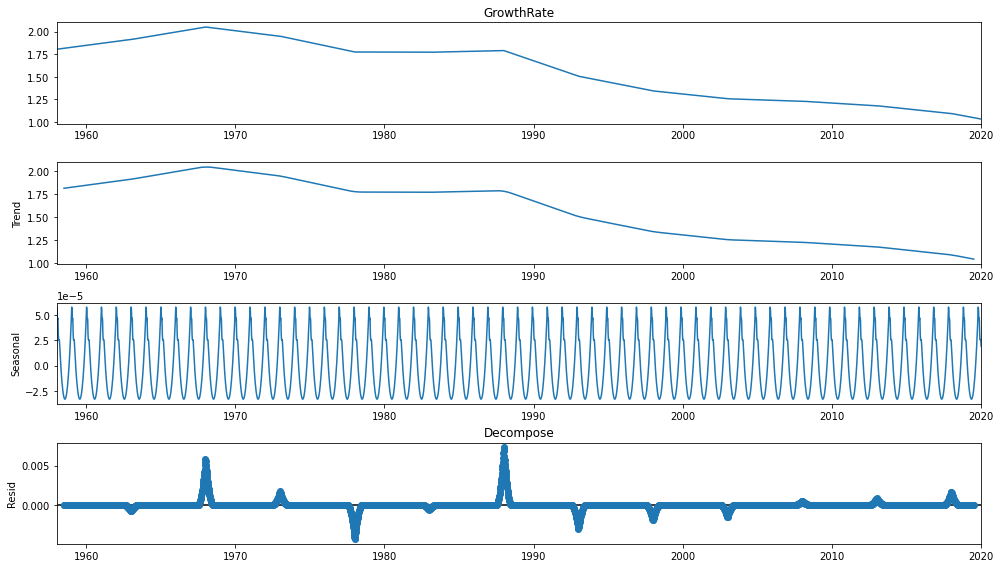

In [ ]:
rcParams['figure.figsize'] = 14, 8
decomp_series = sm.tsa.seasonal_decompose(world_growth.GrowthRate, model='addictive')
decomp_series.plot()
plt.title('Decompose')
plt.show()

### Forecasting the Annual Growth Rate

In [ ]:
train_df = world_growth.iloc[:2000]
test_df = world_growth.iloc[2000:]
test_df

,GrowthRate
MidPeriod,
1996-05-05,1.398095
1996-05-12,1.397470
1996-05-19,1.396846
1996-05-26,1.396221
1996-06-02,1.395596
...,...
2019-12-08,1.034038
2019-12-15,1.033444
2019-12-22,1.032849


#### HoltWinters Exponential Forecast

In [ ]:
model = ExponentialSmoothing(train_df['GrowthRate'],
                             trend='add').fit()

predict = model.forecast(1236)

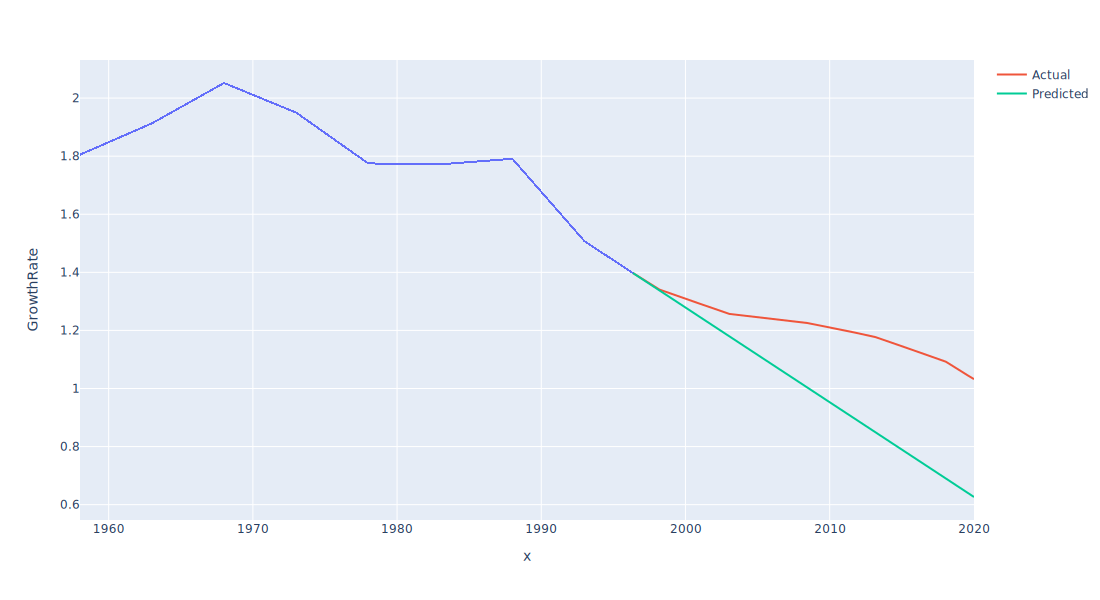

In [ ]:
fig = px.line(train_df, train_df.index, 'GrowthRate')
fig.add_scatter(x=test_df.index, y=test_df.GrowthRate, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show()

##### metrics

In [ ]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

0.18 MAPE
0.25 RMSE


#### ACF and PACF

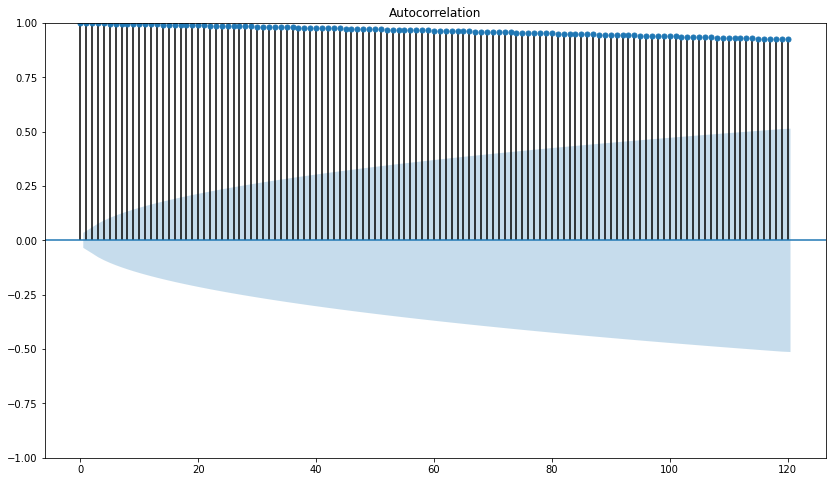

In [ ]:
plot_acf(world_growth, lags=120)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



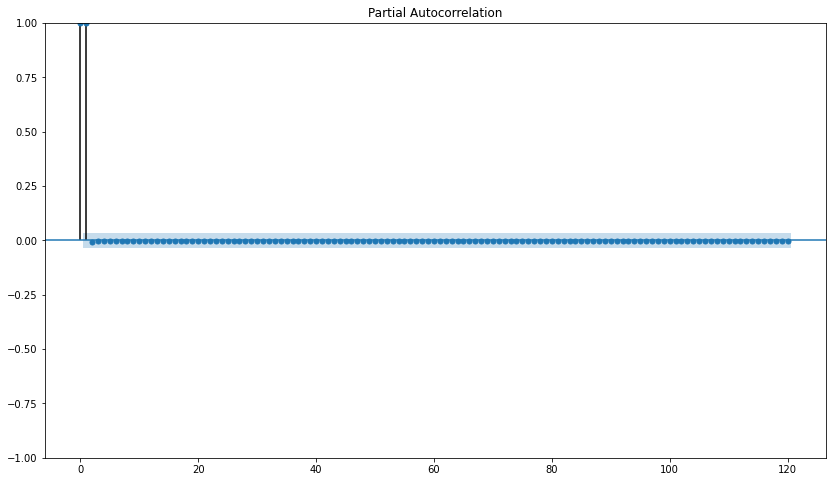

In [ ]:
plot_pacf(world_growth, lags=120)
plt.show()

#### Auto Regressive Forecast

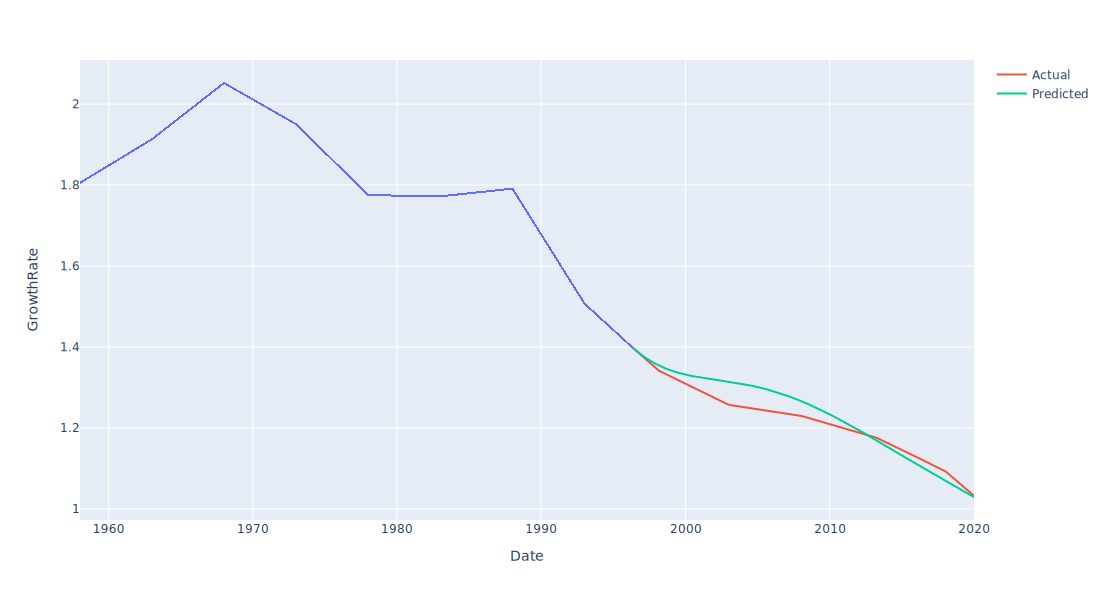

In [ ]:
ar_model = AutoReg(train_df['GrowthRate'], 120, trend='ct').fit(cov_type='HC0')
start = len(train_df)
stop = len(train_df) + len(test_df) -1

predict = ar_model.predict(start=start, end=stop, dynamic=True)
fig = px.line(train_df, train_df.index, 'GrowthRate', labels={'x':'Date'})
fig.add_scatter(x=test_df.index, y=test_df.GrowthRate, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show('svg', height=600, width=1100)

##### metrics


In [ ]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

0.02 MAPE
0.03 RMSE


#### FBProphet Forecast

In [ ]:
world_growth.reset_index(inplace=True)
world_growth = world_growth.rename(columns={'MidPeriod': 'ds', 'GrowthRate': 'y'})
world_growth

,ds,y
0,1958-01-05,1.805237
1,1958-01-12,1.805651
2,1958-01-19,1.806065
3,1958-01-26,1.806479
4,1958-02-02,1.806893
...,...,...
3231,2019-12-08,1.034038
3232,2019-12-15,1.033444
3233,2019-12-22,1.032849
3234,2019-12-29,1.032255


In [ ]:
train_df = world_growth.iloc[:2000]
test_df = world_growth.iloc[2000:]
test_df

model = Prophet(weekly_seasonality=True)
model.fit(train_df)
forecast = model.predict(test_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


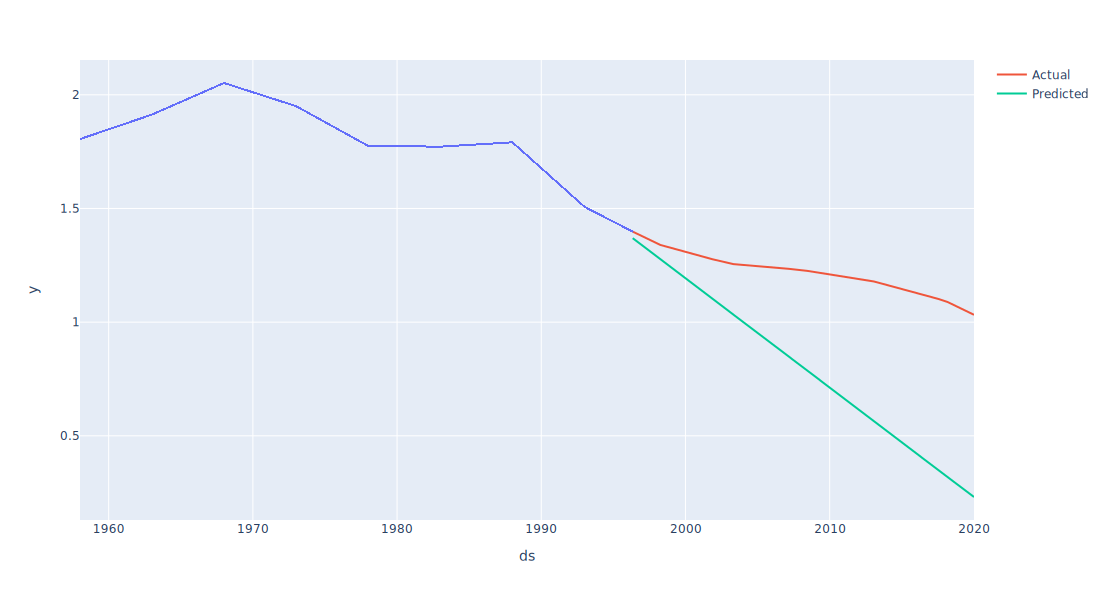

In [ ]:
fig = px.line(train_df, train_df.ds, 'y', labels={'x':'Date'})
fig.add_scatter(x=test_df.ds, y=test_df.y, name='Actual')
fig.add_scatter(x=forecast.ds, y=forecast.yhat, name='Predicted')
fig.show('svg', height=600, width=1100)

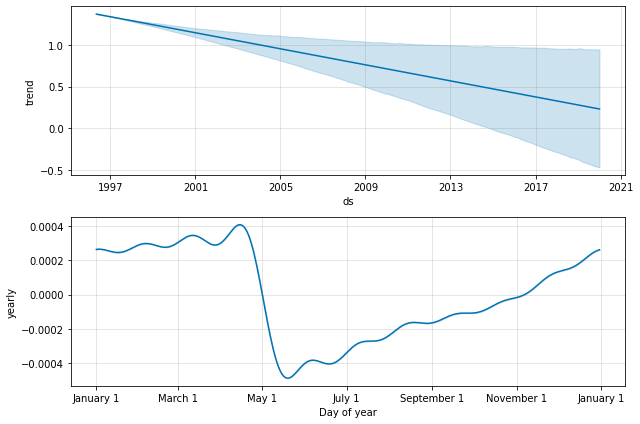

In [ ]:
model.plot_components(forecast)
plt.show()

##### metrics

In [ ]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'])
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df['y']), np.array(forecast['yhat'])))
print('%.2f'%rmse, 'RMSE')

0.36 MAPE
0.49 RMSE
